# Load Data
- using gdown
https://pypi.org/project/gdown/

In [ ]:
!pip install imbalanced-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Builtin Lib
import os

# Installed Lib
import gdown
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso, ElasticNet
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN, RandomOverSampler
from sklearn.neighbors import KNeighborsClassifier
import sklearn
from sklearn.metrics import *
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline

# Define necessaries functions


In [ ]:
#Load Data to Local
def load_data():
    url = "https://drive.google.com/drive/folders/1-vqyfpMhuUjF0t_USdvoXMkW7HtuA0op"
    gdown.download_folder(url, quiet=True, use_cookies=False)
    print("Finish Download")

def check_file_exist_in_local():
    path = "/content/data-home-temp"
    is_exists = os.path.exists(path)
    if is_exists:
        print(is_exists)
    else:
        print("Folder does not exists")

def read_file(path):
    return pd.read_csv(path)

#Define treshold for Binary Classification model
def get_classs_temp(temp):
    if temp < 20:
        return 0
    else:
        return 1

def get_classs_temps(temps):
    return [get_classs_temp(temp) for temp in temps]

#Correlation plot
def plot_correlation(df, is_save=False):
    df_corr = df.corr().abs()
    plt.figure(figsize=(12,8))
    mask = np.triu(np.ones_like(df_corr, dtype=bool))
    sns.heatmap(df_corr, annot=True, fmt=".2f", linewidths=.5, mask=mask, robust=True)
    plt.show()

    if is_save:
        plt.savefig('./correlation.png')

#Split data
def split_train_test1(df, features, train_size=0.8):
    train_idx = int(len(df) * train_size)
    df_train_prepared = df[features + ["Id", "Indoor_temperature_room"]][:train_idx]
    df_valid_prepared = df[features + ["Id", "Indoor_temperature_room"]][train_idx:]
    return df_train_prepared, df_valid_prepared

def split_train_test2(df, features, train_size=0.8):
    train_idx = int(len(df) * train_size)
    df_train = df[features + ["Id", "Indoor_temperature_room", "Temp_Class"]][:train_idx]
    df_test = df[features + ["Id", "Indoor_temperature_room", "Temp_Class"]][train_idx:]
    return df_train, df_test

def generate_list_timeseries_cv(x_train, cv=20):
    tscv = TimeSeriesSplit(n_splits=cv, test_size=100)

    cv_ls = []
    for idx, (train_index, valid_index) in zip(range(0, 20, 1), tscv.split(x_train)):
        cv_ls.append((train_index[idx*100:], valid_index))
    return cv_ls

#Cost function
def cost_electricity(y_trues, y_preds):
    cost = 0
    for y_true, y_pred in zip(y_trues, y_preds):
        if (y_true == 0) & (y_pred == 1):
            cost += 100
        else:
            cost += 0
    return cost

#Transformation Function
def initiate_estimator(params):
    knn = KNeighborsClassifier(**params)
    return knn

def retrain_with_best_parameters(estimator, x_train, y_train):
    estimator.fit(x_train, y_train)
    return estimator

def norm_train_test(x_train, x_test):
    norm = MinMaxScaler()
    x_train_norm = norm.fit_transform(x_train)
    x_test_norm = norm.transform(x_test)
    return x_train_norm, x_test_norm

def std_train_test(x_train, x_test):
    std = StandardScaler()
    x_train_std = std.fit_transform(x_train)
    x_test_std = std.transform(x_test)
    return x_train_std, x_test_std

#Oversampling Function
def do_rand(x_train, y_train):
    rand = RandomOverSampler(random_state=2022, sampling_strategy='minority')
    x_train_rand, y_train_rand = rand.fit_resample(x_train, y_train)
    return x_train_rand, y_train_rand

def do_smote(x_train, y_train):
    smote = SMOTE(random_state=2022, sampling_strategy='minority')
    x_train_smote, y_train_smote = smote.fit_resample(x_train, y_train)
    return x_train_smote, y_train_smote

def do_bord(x_train, y_train):
    bord = BorderlineSMOTE(random_state=2022, sampling_strategy='minority')
    x_train_bord, y_train_bord = bord.fit_resample(x_train, y_train)
    return x_train_bord, y_train_bord

def do_adasyn(x_train, y_train):
    adasyn = ADASYN(random_state=2022, sampling_strategy='minority')
    x_train_adasyn, y_train_adasyn = adasyn.fit_resample(x_train, y_train)
    return x_train_adasyn, y_train_adasyn

#Performance Function
def predict_with_best_model(estimator, x_train, x_test):
    y_train_preds = estimator.predict(x_train)
    y_test_preds = estimator.predict(x_test)
    return y_train_preds, y_test_preds

def avg_f1(y_trues, y_preds):
    avg_f1 = (f1_score(y_trues, y_preds, pos_label=0) + f1_score(y_trues, y_preds, pos_label=1))/2
    return avg_f1

def check_performance_metrics(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print(classification_report(y_train_true, y_train_pred, target_names=["Temp < 20", "Temp >= 20"]))
    print(classification_report(y_test_true, y_test_pred, target_names=["Temp < 20", "Temp >= 20"]))

    print(f"ROC AUC Score Train: {roc_auc_score(y_train, y_train_model_prob[:, 1]) * 100:.4f} %")
    print(f"ROC AUC Score Val: {roc_auc_score(y_val, y_val_model_prob[:, 1]) * 100:.4f} %")

    print(f"AVG Electricity Cost Train: {cost_electricity(y_train_true, y_train_pred)/len(y_train_true):.4f} Baht")
    print(f"AVG Electricity Cost Val: {cost_electricity(y_test_true, y_test_pred)/len(y_test_true):.4f} Baht")

    print(f"AVG F1 Score Train: {avg_f1(y_train_true, y_train_pred)*100:.4f} %")
    print(f"AVG F1 Score Val: {avg_f1(y_test_true, y_test_pred)*100:.4f} %")


# Step Code


In [ ]:
load_data()
check_file_exist_in_local()

df_train = read_file("/content/data-home-temp/train.csv")
df_test = read_file("/content/data-home-temp/test.csv")

Finish Download
True


<ipython-input-4-e48fa8f24c85>:30: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_corr = df.corr().abs()


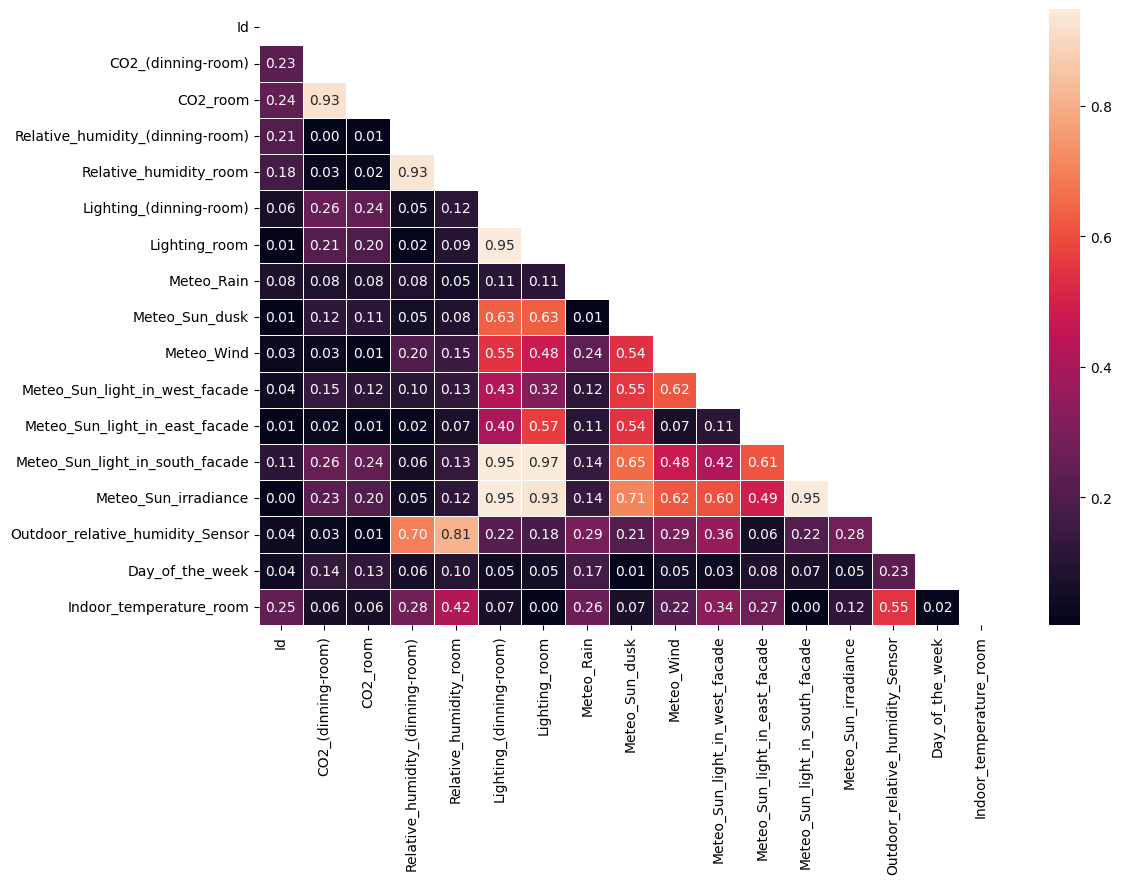

<Figure size 640x480 with 0 Axes>

In [ ]:
plot_correlation(df_train, is_save=True)

#Regression

In [ ]:
#Define features columns
FEATURES_COLUMNS = [
    "CO2_room",
    "Relative_humidity_room",
    "Meteo_Sun_irradiance",
    'Meteo_Rain',
    'Meteo_Sun_dusk',
    'Meteo_Wind',
    'Meteo_Sun_light_in_west_facade',
    'Meteo_Sun_light_in_east_facade',
    'Outdoor_relative_humidity_Sensor',
    'Day_of_the_week'
]

In [ ]:
#Define X_train,X_val,y_train,y_val
df_train_prepared, df_valid_prepared = split_train_test1(df_train, FEATURES_COLUMNS, train_size=0.8)
print(f"Train shape: {df_train_prepared.shape}")
print(f"Val shape: {df_valid_prepared.shape}")

X_train = df_train_prepared[FEATURES_COLUMNS].values
X_val = df_valid_prepared[FEATURES_COLUMNS].values

y_train = df_train_prepared["Indoor_temperature_room"].values
y_val = df_valid_prepared["Indoor_temperature_room"].values

print(f"X Train shape: {X_train.shape}")
print(f"X Val shape: {X_val.shape}")
print(f"Y Train shape: {y_train.shape}")
print(f"Y Val shape: {y_val.shape}")

Train shape: (2211, 12)
Val shape: (553, 12)
X Train shape: (2211, 10)
X Val shape: (553, 10)
Y Train shape: (2211,)
Y Val shape: (553,)


In [ ]:
# Normalization and Standardization
def norm_train_test(x_train, x_val):
    norm = MinMaxScaler()
    X_train_norm = norm.fit_transform(X_train)
    X_val_norm = norm.transform(X_val)
    return X_train_norm, X_val_norm

def std_train_test(x_train, x_val):
    std = StandardScaler()
    X_train_std = std.fit_transform(X_train_norm)
    X_val_std = std.transform(X_val_norm)
    return X_train_std, X_val_std

In [ ]:
X_train_norm, X_val_norm = norm_train_test(X_train, X_val)
X_train_std, X_val_std = std_train_test(X_train_norm, X_val_norm)

##Model 1 (Linear Regression)

In [ ]:
lin_reg = LinearRegression()

In [ ]:
lin_reg.fit(X_train_std, y_train)

LinearRegression()

In [ ]:
y_train_pred = lin_reg.predict(X_train_std)

In [ ]:
y_val_pred = lin_reg.predict(X_val_std)

In [ ]:
from sklearn.metrics import *

In [ ]:
print("R-Square Train: ", r2_score(y_train, y_train_pred))
print("R-Square Validation: ",r2_score(y_val, y_val_pred))
print("MSE Train: ", median_absolute_error(y_train, y_train_pred))
print("MSE Validation: ", median_absolute_error(y_val, y_val_pred))

R-Square Train:  0.479568752669152
R-Square Validation:  0.20518282557026513


###Check Polynomial

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

In [ ]:
poly_reg = PolynomialFeatures(degree=4)

In [ ]:
X_train_poly = poly_reg.fit_transform(X_train_std)
X_val_poly = poly_reg.transform(X_val_std)

In [ ]:
lin_reg2 = LinearRegression()

In [ ]:
lin_reg2.fit(X_train_poly, y_train)

LinearRegression()

In [ ]:
y_train_poly_pred = lin_reg2.predict(X_train_poly)
y_val_poly_pred = lin_reg2.predict(X_val_poly)

In [ ]:
print("R-Square Train: ", r2_score(y_train, y_train_poly_pred))
print("R-Square Validation: ",r2_score(y_val, y_val_poly_pred))
print("MSE Train: ", median_absolute_error(y_train, y_train_poly_pred))
print("MSE Validation: ", median_absolute_error(y_val, y_val_poly_pred))

R-Square Train:  0.964633318199815
R-Square Validation:  -840473664.0887684
MSE Train:  0.23816047576367794
MSE Validation:  5.189850504862889


###Regularization

####Ridge

In [ ]:
ridge_reg = Ridge()
ridge_reg.fit(X_train_std, y_train)

Ridge()

In [ ]:
y_train_std_ridge_pred = ridge_reg.predict(X_train_std)
y_val_std_ridge_pred = ridge_reg.predict(X_val_std)

In [ ]:
print("Ridge std R-Square Train: ", r2_score(y_train, y_train_std_ridge_pred))
print("Ridge std R-Square Validation: ",r2_score(y_val, y_val_std_ridge_pred))
print("="*50)
print("Ridge std MAE Train: ", mean_absolute_error(y_train, y_train_std_ridge_pred))
print("Ridge std MAE Validation: ", mean_absolute_error(y_val, y_val_std_ridge_pred))
print("="*50)

Ridge std R-Square Train:  0.47956861657832595
Ridge std R-Square Validation:  0.20536470696683928
Ridge std MAE Train:  1.6582557667918163
Ridge std MAE Validation:  1.8424508503585835


#### Ridge Polynomail

In [ ]:
ridge_reg.fit(X_train_poly, y_train)

Ridge()

In [ ]:
y_train_poly_ridge_pred = ridge_reg.predict(X_train_poly)
y_val_poly_ridge_pred = ridge_reg.predict(X_val_poly)

In [ ]:
print("Ridge Poly R-Square Train: ", r2_score(y_train, y_train_poly_ridge_pred))
print("Ridge Poly R-Square Validation: ",r2_score(y_val, y_val_poly_ridge_pred))
print("="*50)
print("Ridge Poly MAE Train: ", mean_absolute_error(y_train, y_train_poly_ridge_pred))
print("Ridge Poly MAE Validation: ", mean_absolute_error(y_val, y_val_poly_ridge_pred))
print("="*50)

Ridge Poly R-Square Train:  0.9078542612449654
Ridge Poly R-Square Validation:  -7.316803077770892
Ridge Poly MAE Train:  0.5840463707794139
Ridge Poly MAE Validation:  4.4190359982873


####Lasso

In [ ]:
lasso_reg = Lasso()
lasso_reg.fit(X_train_std, y_train)

Lasso()

In [ ]:
y_train_std_lasso_pred = lasso_reg.predict(X_train_std)
y_val_std_lasso_pred = lasso_reg.predict(X_val_std)

In [ ]:
print("Lasso std R-Square Train: ", r2_score(y_train, y_train_std_lasso_pred))
print("Lasso std R-Square Validation: ",r2_score(y_val, y_val_std_lasso_pred))
print("="*50)
print("Lasso std MAE Train: ", mean_absolute_error(y_train, y_train_std_lasso_pred))
print("Lasso std MAE Validation: ", mean_absolute_error(y_val, y_val_std_lasso_pred))
print("="*50)

Lasso std R-Square Train:  0.20841866310259438
Lasso std R-Square Validation:  0.08433941836415304
Lasso std MAE Train:  2.1073318027435324
Lasso std MAE Validation:  1.9412363171959872


#### Lasso Polynomial

In [ ]:
lasso_reg.fit(X_train_poly, y_train)

Lasso()

In [ ]:
y_train_poly_lasso_pred = lasso_reg.predict(X_train_poly)
y_val_poly_lasso_pred = lasso_reg.predict(X_val_poly)

In [ ]:
print("Lasso poly R-Square Train: ", r2_score(y_train, y_train_poly_lasso_pred))
print("Lasso poly R-Square Validation: ",r2_score(y_val, y_val_poly_lasso_pred))
print("="*50)
print("Lasso poly MAE Train: ", mean_absolute_error(y_train, y_train_poly_lasso_pred))
print("Lasso poly MAE Validation: ", mean_absolute_error(y_val, y_val_poly_lasso_pred))
print("="*50)

Lasso poly R-Square Train:  0.4256477477689252
Lasso poly R-Square Validation:  0.3296252875421378
Lasso poly MAE Train:  1.732931741281465
Lasso poly MAE Validation:  1.6263622619805338


####Elastic net

In [ ]:
elasticnet_reg = ElasticNet()
elasticnet_reg.fit(X_train_std, y_train)

ElasticNet()

In [ ]:
y_train_std_elasticnet_pred = elasticnet_reg.predict(X_train_std)
y_val_std_elasticnet_pred = elasticnet_reg.predict(X_val_std)

In [ ]:
print("Elasticnet std R-Square Train: ", r2_score(y_train, y_train_std_elasticnet_pred))
print("Elasticnet std R-Square Validation: ",r2_score(y_val, y_val_std_elasticnet_pred))
print("="*50)
print("Elasticnet std MAE Train: ", mean_absolute_error(y_train, y_train_std_elasticnet_pred))
print("Elasticnet std MAE Validation: ", mean_absolute_error(y_val, y_val_std_elasticnet_pred))
print("="*50)

Elasticnet std R-Square Train:  0.2999922544492427
Elasticnet std R-Square Validation:  0.17624227401331272
Elasticnet std MAE Train:  1.992367675540748
Elasticnet std MAE Validation:  1.8506739431632457


####Elasticnet Polynomial

In [ ]:
elasticnet_reg.fit(X_train_poly, y_train)

ElasticNet()

In [ ]:
y_train_poly_elasticnet_pred = elasticnet_reg.predict(X_train_poly)
y_val_poly_elasticnet_pred = elasticnet_reg.predict(X_val_poly)

In [ ]:
print("Elasticnet poly R-Square Train: ", r2_score(y_train, y_train_poly_elasticnet_pred))
print("Elasticnet poly R-Square Validation: ",r2_score(y_val, y_val_poly_elasticnet_pred))
print("="*50)
print("Elasticnet poly MAE Train: ", mean_absolute_error(y_train, y_train_poly_elasticnet_pred))
print("Elasticnet poly MAE Validation: ", mean_absolute_error(y_val, y_val_poly_elasticnet_pred))
print("="*50)

Elasticnet poly R-Square Train:  0.4828681355285428
Elasticnet poly R-Square Validation:  0.3160856008511276
Elasticnet poly MAE Train:  1.6445329240927602
Elasticnet poly MAE Validation:  1.6556851475872663


#### Conclusion Linear Regression

In [ ]:
print("Ridge std R-Square Train: ", r2_score(y_train, y_train_std_ridge_pred))
print("Ridge std R-Square Validation: ",r2_score(y_val, y_val_std_ridge_pred))
print("="*50)
print("Ridge std MAE Train: ", mean_absolute_error(y_train, y_train_std_ridge_pred))
print("Ridge std MAE Validation: ", mean_absolute_error(y_val, y_val_std_ridge_pred))
print("="*50)

print("Ridge Poly R-Square Train: ", r2_score(y_train, y_train_poly_ridge_pred))
print("Ridge Poly R-Square Validation: ",r2_score(y_val, y_val_poly_ridge_pred))
print("="*50)
print("Ridge Poly MAE Train: ", mean_absolute_error(y_train, y_train_poly_ridge_pred))
print("Ridge Poly MAE Validation: ", mean_absolute_error(y_val, y_val_poly_ridge_pred))
print("="*50)

print("Lasso std R-Square Train: ", r2_score(y_train, y_train_std_lasso_pred))
print("Lasso std R-Square Validation: ",r2_score(y_val, y_val_std_lasso_pred))
print("="*50)
print("Lasso std MAE Train: ", mean_absolute_error(y_train, y_train_std_lasso_pred))
print("Lasso std MAE Validation: ", mean_absolute_error(y_val, y_val_std_lasso_pred))
print("="*50)

print("Lasso poly R-Square Train: ", r2_score(y_train, y_train_poly_lasso_pred))
print("Lasso poly R-Square Validation: ",r2_score(y_val, y_val_poly_lasso_pred))
print("="*50)
print("Lasso poly MAE Train: ", mean_absolute_error(y_train, y_train_poly_lasso_pred))
print("Lasso poly MAE Validation: ", mean_absolute_error(y_val, y_val_poly_lasso_pred))
print("="*50)

print("Elasticnet std R-Square Train: ", r2_score(y_train, y_train_std_elasticnet_pred))
print("Elasticnet std R-Square Validation: ",r2_score(y_val, y_val_std_elasticnet_pred))
print("="*50)
print("Elasticnet std MAE Train: ", mean_absolute_error(y_train, y_train_std_elasticnet_pred))
print("Elasticnet std MAE Validation: ", mean_absolute_error(y_val, y_val_std_elasticnet_pred))
print("="*50)

print("Elasticnet poly R-Square Train: ", r2_score(y_train, y_train_poly_elasticnet_pred))
print("Elasticnet poly R-Square Validation: ",r2_score(y_val, y_val_poly_elasticnet_pred))
print("="*50)
print("Elasticnet poly MAE Train: ", mean_absolute_error(y_train, y_train_poly_elasticnet_pred))
print("Elasticnet poly MAE Validation: ", mean_absolute_error(y_val, y_val_poly_elasticnet_pred))
print("="*50)

Ridge std R-Square Train:  0.47956861657832595
Ridge std R-Square Validation:  0.20536470696683928
Ridge std MAE Train:  1.6582557667918163
Ridge std MAE Validation:  1.8424508503585835
Ridge Poly R-Square Train:  0.9078542612449654
Ridge Poly R-Square Validation:  -7.316803077770892
Ridge Poly MAE Train:  0.5840463707794139
Ridge Poly MAE Validation:  4.4190359982873
Lasso std R-Square Train:  0.20841866310259438
Lasso std R-Square Validation:  0.08433941836415304
Lasso std MAE Train:  2.1073318027435324
Lasso std MAE Validation:  1.9412363171959872
Lasso poly R-Square Train:  0.4256477477689252
Lasso poly R-Square Validation:  0.3296252875421378
Lasso poly MAE Train:  1.732931741281465
Lasso poly MAE Validation:  1.6263622619805338
Elasticnet std R-Square Train:  0.2999922544492427
Elasticnet std R-Square Validation:  0.17624227401331272
Elasticnet std MAE Train:  1.992367675540748
Elasticnet std MAE Validation:  1.8506739431632457
Elasticnet poly R-Square Train:  0.4828681355285428



| Model                     | R-Square Train | R-Square Validation | MAE Train | MAE Validation |
|---------------------------|----------------|---------------------|-----------|----------------|
| Lasso poly                |   0.425648     |      0.329625       |  1.732932 |     1.626362   |
| Elasticnet poly           |   0.482868     |      0.316086       |  1.644533 |     1.655685   |
| Ridge std                 |   0.479569     |      0.205365       |  1.658256 |     1.842451   |
| Elasticnet std            |   0.299992     |      0.176242       |  1.992368 |     1.850674   |
| Lasso std                 |   0.208419     |      0.084339       |  2.107332 |     1.941236   |
| Ridge Poly                |   0.907854     |     -7.316803       |  0.584046 |     4.419036   |

The Lasso poly model is correctly placed at the top with the highest R-Square Validation of 0.329625.

###Alpha effects

####Grid Search

ความเข้มข้นของ บาเรีย (เลขตัวคูณหน้า ริช แลซโซ อีลาสติก)
ปกติค่า default จะเป็น 1 เมื่อทำ grid serch จะเป็นการหาตัวคูณ weight บาเรีย ว่าบาเรียเข้มข้นระดับไหน model ถึงจะมี eror น้อยสุด

In [ ]:
import sklearn
from sklearn.model_selection import GridSearchCV

In [ ]:
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'matthews_corrcoef', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'top_k_accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'positive_likelihood_ratio', 'neg_negative_likelihood_ratio', 'adjusted_rand_score', 'rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weig

In [ ]:
param_grid = {'alpha':[0.0005, 0.0006, 0.06, 0.5, 0.0001, 0.01, 1, 2, 3, 4, 5, 10, 20, 30, 40]}

In [ ]:
gs_lasso_reg = Lasso(random_state=2022)

In [ ]:
grid = GridSearchCV(estimator=gs_lasso_reg, param_grid=param_grid, scoring="neg_mean_squared_error", n_jobs=-1)
grid.fit(X_train_poly, y_train)
print(grid)

GridSearchCV(estimator=Lasso(random_state=2022), n_jobs=-1,
             param_grid={'alpha': [0.0005, 0.0006, 0.06, 0.5, 0.0001, 0.01, 1,
                                   2, 3, 4, 5, 10, 20, 30, 40]},
             scoring='neg_mean_squared_error')


In [ ]:
print(grid.best_score_)
print(grid.best_estimator_.alpha)

-8.774152241328794
5


In [ ]:
opt_lasso_reg = Lasso(alpha=5,random_state=2022)

In [ ]:
opt_lasso_reg.fit(X_train_poly, y_train)

Lasso(alpha=5, random_state=2022)

In [ ]:
y_train_poly_opt_lasso_pred = opt_lasso_reg.predict(X_train_poly)
y_val_poly_opt_lasso_pred = opt_lasso_reg.predict(X_val_poly)

In [ ]:
print("R-Square Train: ", r2_score(y_train, y_train_poly_opt_lasso_pred))
print("R-Square Validation: ",r2_score(y_val, y_val_poly_opt_lasso_pred))
print("="*50)
print("MAE Train: ", mean_absolute_error(y_train, y_train_poly_opt_lasso_pred))
print("MAE Validation: ", mean_absolute_error(y_val, y_val_poly_opt_lasso_pred))
print("="*50)

R-Square Train:  0.23180365358955035
R-Square Validation:  0.09105194750166457
MAE Train:  1.9722250989034216
MAE Validation:  1.8961563460764912


####Random Search

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform as sp_rand

In [ ]:
param_grid = {'alpha': sp_rand()}

In [ ]:
gs_lasso_reg = Lasso(random_state=2022)

In [ ]:
rsearch = RandomizedSearchCV(estimator=gs_lasso_reg, param_distributions=param_grid, scoring="neg_mean_squared_error", n_jobs=-1)

In [ ]:
rsearch.fit(X_train_poly, y_train)

RandomizedSearchCV(estimator=Lasso(random_state=2022), n_jobs=-1,
                   param_distributions={'alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f55e7a5ea70>},
                   scoring='neg_mean_squared_error')

In [ ]:
print(rsearch.best_score_)
print(rsearch.best_estimator_.alpha)

-9.271803450078627
0.9284139067779377


In [ ]:
opt_lasso_reg = Lasso(alpha=0.9284139067779377, random_state=2022)

In [ ]:
opt_lasso_reg.fit(X_train_poly, y_train)

y_train_poly_opt_lasso_pred = opt_lasso_reg.predict(X_train_poly)
y_val_poly_opt_lasso_pred = opt_lasso_reg.predict(X_val_poly)

In [ ]:
print("R-Square Train: ", r2_score(y_train, y_train_poly_opt_lasso_pred))
print("R-Square Validation: ",r2_score(y_val, y_val_poly_opt_lasso_pred))
print("="*50)
print("MAE Train: ", mean_absolute_error(y_train, y_train_poly_opt_lasso_pred))
print("MAE Validation: ", mean_absolute_error(y_val, y_val_poly_opt_lasso_pred))
print("="*50)

R-Square Train:  0.43216827067983576
R-Square Validation:  0.33320402971661167
MAE Train:  1.7235538444701286
MAE Validation:  1.620332073170938


####Conclusion

จากการปรับค่า Alpha ของ Lasso with polynomial พบว่า การใช้ Random search จะได้ค่า alpha = 0.9284139067779377 พบว่าได้ค่าที่ดีขึ้นทั้งในส่วนของ R2 และ MAE
*   Without Alpha effect
1.   Lasso poly R-Square Train:         0.425
2.   Lasso poly R-Square Validation:  0.329
3.   Lasso poly MAE Train:               1.732
4.   Lasso poly MAE Validation:        1.626
*   With Alpha effect
1.   Lasso poly R-Square Train:        0.432
2.   Lasso poly R-Square Validation:   0.333
3.   Lasso poly MAE Train:               1.723
4.   Lasso poly MAE Validation:       1.620








##Model 2 (Decison Tree Regressor)

In [ ]:
print(f"X Train shape: {X_train.shape}")
print(f"X Val shape: {X_val.shape}")
print(f"Y Train shape: {y_train.shape}")
print(f"Y Val shape: {y_val.shape}")

X Train shape: (2211, 10)
X Val shape: (553, 10)
Y Train shape: (2211,)
Y Val shape: (553,)


In [ ]:
from sklearn.tree import DecisionTreeRegressor
import sklearn
from sklearn.metrics import *
from sklearn.model_selection import GridSearchCV

In [ ]:
param_grid = {'max_depth': [5, 6, 7, 8, 9, 10, 11, 12]}

In [ ]:
clf_tree = DecisionTreeRegressor(random_state=2022)

In [ ]:
grid = GridSearchCV(estimator=clf_tree,
                    param_grid=param_grid,
                    scoring="neg_mean_squared_error",
                    n_jobs=-1)

grid.fit(X_train_std, y_train)

GridSearchCV(estimator=DecisionTreeRegressor(random_state=2022), n_jobs=-1,
             param_grid={'max_depth': [5, 6, 7, 8, 9, 10, 11, 12]},
             scoring='neg_mean_squared_error')

In [ ]:
print(grid.best_score_)
print(grid.best_estimator_.max_depth)

-9.407571220901517
5


In [ ]:
opt_clf_tree = DecisionTreeRegressor(max_depth=5, random_state=2022)
opt_clf_tree.fit(X_train_std, y_train)

DecisionTreeRegressor(max_depth=5, random_state=2022)

In [ ]:
y_train_opt_clf_tree = opt_clf_tree.predict(X_train_std)
y_val_opt_clf_tree = opt_clf_tree.predict(X_val_std)

In [ ]:
print("R-Square Train: ", r2_score(y_train, y_train_opt_clf_tree))
print("R-Square Validation: ", r2_score(y_val, y_val_opt_clf_tree))
print("="*50)
print("MAE Train: ", mean_absolute_error(y_train, y_train_opt_clf_tree))
print("MAE Validation: ", mean_absolute_error(y_val, y_val_opt_clf_tree))
print("="*50)

R-Square Train:  0.6972484252902791
R-Square Validation:  0.3669053663087176
MAE Train:  1.167088442702558
MAE Validation:  1.6476039712646395


###Check Polynomial

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

In [ ]:
poly_reg = PolynomialFeatures(degree=4)

In [ ]:
X_train_poly = poly_reg.fit_transform(X_train_std)
X_val_poly = poly_reg.transform(X_val_std)

In [ ]:
grid = GridSearchCV(estimator=clf_tree,
                    param_grid=param_grid,
                    scoring="neg_mean_squared_error",
                    n_jobs=-1)

grid.fit(X_train_poly, y_train)

GridSearchCV(estimator=DecisionTreeRegressor(random_state=2022), n_jobs=-1,
             param_grid={'max_depth': [5, 6, 7, 8, 9, 10, 11, 12]},
             scoring='neg_mean_squared_error')

In [ ]:
print(grid.best_score_)
print(grid.best_estimator_.max_depth)

-10.881663787176585
5


In [ ]:
opt_clf_tree = DecisionTreeRegressor(max_depth=5, random_state=2022)
opt_clf_tree.fit(X_train_poly, y_train)

DecisionTreeRegressor(max_depth=5, random_state=2022)

In [ ]:
y_train_poly_opt_clf_tree = opt_clf_tree.predict(X_train_poly)
y_val_poly_opt_clf_tree = opt_clf_tree.predict(X_val_poly)

In [ ]:
print("R-Square Train: ", r2_score(y_train, y_train_poly_opt_clf_tree))
print("R-Square Validation: ", r2_score(y_val, y_val_poly_opt_clf_tree))
print("="*50)
print("MAE Train: ", mean_absolute_error(y_train, y_train_poly_opt_clf_tree))
print("MAE Validation: ", mean_absolute_error(y_val, y_val_poly_opt_clf_tree))
print("="*50)

R-Square Train:  0.8180687108293496
R-Square Validation:  -0.0986614546523934
MAE Train:  0.8975093827233768
MAE Validation:  2.0439414365212807


### Strategy on Spliting in Timeseries Dataset

In [ ]:
from sklearn.model_selection import TimeSeriesSplit

In [ ]:
tscv = TimeSeriesSplit(n_splits=20, test_size=100)

cv_ls = []
for train_index, valid_index in tscv.split(X_train_std):
    cv_ls.append((train_index, valid_index))

#### Check split

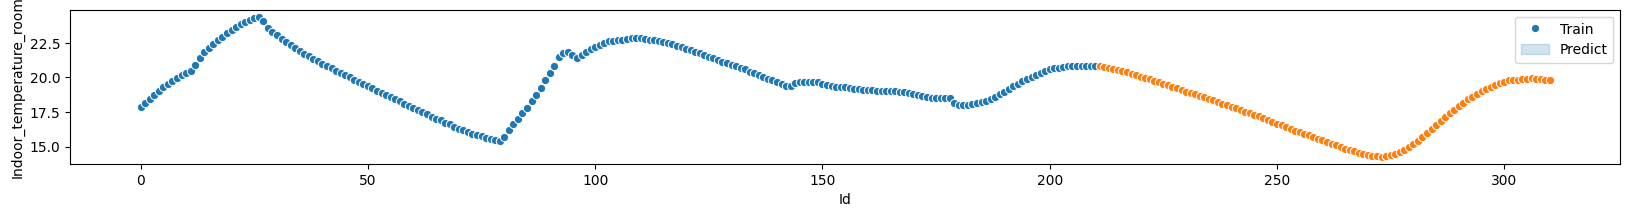

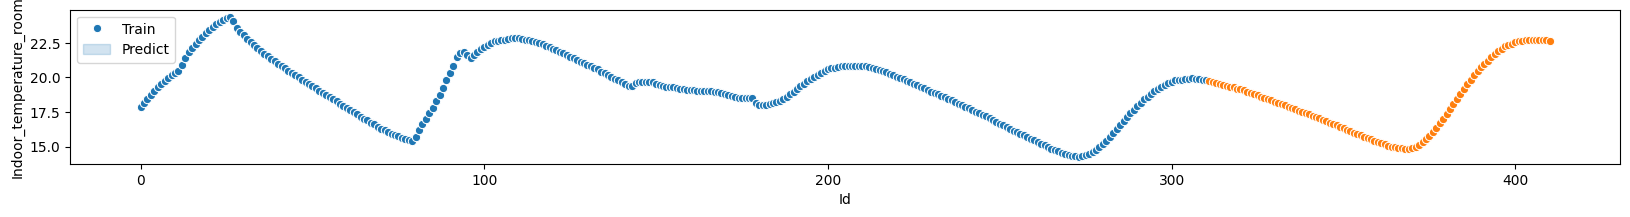

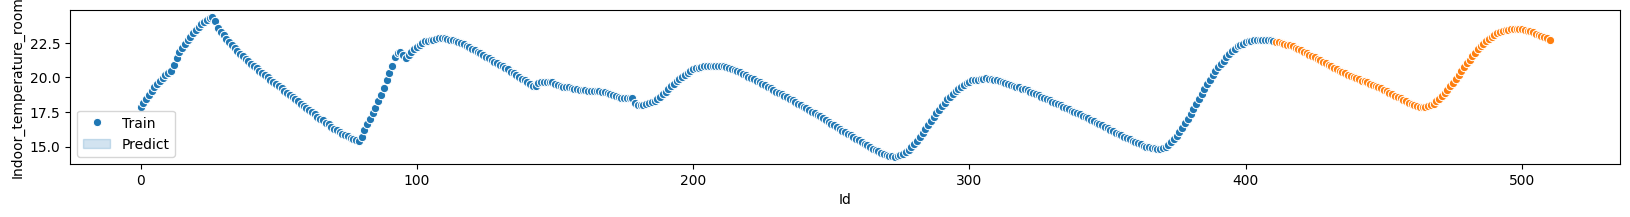

In [ ]:
plt.figure(figsize=(20, 2))
sns.lineplot(data=df_train_prepared.iloc[cv_ls[0][0]], x="Id", y="Indoor_temperature_room", marker='o', linestyle='')
sns.lineplot(data=df_train_prepared.iloc[cv_ls[0][1]], x="Id", y="Indoor_temperature_room", marker='o', linestyle='')
plt.legend(["Train", "Predict"])

plt.figure(figsize=(20, 2))
sns.lineplot(data=df_train_prepared.iloc[cv_ls[1][0]], x="Id", y="Indoor_temperature_room", marker='o', linestyle='')
sns.lineplot(data=df_train_prepared.iloc[cv_ls[1][1]], x="Id", y="Indoor_temperature_room", marker='o', linestyle='')
plt.legend(["Train", "Predict"])

plt.figure(figsize=(20, 2))
sns.lineplot(data=df_train_prepared.iloc[cv_ls[2][0]], x="Id", y="Indoor_temperature_room", marker='o', linestyle='')
sns.lineplot(data=df_train_prepared.iloc[cv_ls[2][1]], x="Id", y="Indoor_temperature_room", marker='o', linestyle='')
plt.legend(["Train", "Predict"])

### Tuning Again

In [ ]:
clf_tree = DecisionTreeRegressor(random_state=2022)

In [ ]:
param_grid = {'max_depth': [5, 6, 7, 8, 9, 10, 11, 12],
              'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10],
              'max_features': ["auto", "sqrt", "log2"]}

In [ ]:
grid = GridSearchCV(estimator=clf_tree,
                    param_grid=param_grid,
                    scoring="neg_mean_squared_error",
                    cv=cv_ls,
                    n_jobs=-1)

grid.fit(X_train_std, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(


GridSearchCV(cv=[(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108...
       2177, 2178, 2179, 2180, 2181, 2182, 2183, 2184, 2185, 2186, 2187,
       2188, 2189, 2190, 2191, 2192, 2193, 2194, 2195, 2196, 2197, 2198,
       2199, 2200, 2201, 2202, 2203, 2204, 2205, 2206, 2207, 2208, 2209,
       2210]))],
             estimator=DecisionTreeRegressor(random_state=2022), n_jobs=-1,
             param_grid={'max_depth': [5, 6, 7, 8, 9, 10, 11, 12],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10]},
             scoring='neg_mean_squared_error')

In [ ]:
print(grid.best_score_)
print(grid.best_estimator_)

-7.552915719621742
DecisionTreeRegressor(max_depth=5, max_features='auto', min_samples_split=7,
                      random_state=2022)


In [ ]:
opt_clf_tree = DecisionTreeRegressor(max_depth=5, max_features='auto', min_samples_split=7, random_state=2022)
opt_clf_tree.fit(X_train_std, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(


DecisionTreeRegressor(max_depth=5, max_features='auto', min_samples_split=7,
                      random_state=2022)

In [ ]:
y_train_opt_clf_tree = opt_clf_tree.predict(X_train_std)
y_val_opt_clf_tree = opt_clf_tree.predict(X_val_std)

In [ ]:
print("R-Square Train: ", r2_score(y_train, y_train_opt_clf_tree))
print("R-Square Validation: ", r2_score(y_val, y_val_opt_clf_tree))
print("="*50)
print("MAE Train: ", mean_absolute_error(y_train, y_train_opt_clf_tree))
print("MAE Validation: ", mean_absolute_error(y_val, y_val_opt_clf_tree))
print("="*50)

R-Square Train:  0.6972484252902791
R-Square Validation:  0.3669053663087176
MAE Train:  1.167088442702558
MAE Validation:  1.6476039712646395


##Model 3 (Random Forest)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
clf_rand = RandomForestRegressor(random_state=2022)

In [ ]:
param_grid = {
    'n_estimators': [100,200],
    'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
    'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10],
    'max_features': ["auto", "sqrt", "log2"]}

In [ ]:
grid = GridSearchCV(estimator=clf_rand,
                    param_grid=param_grid,
                    scoring="neg_mean_squared_error",
                    cv=cv_ls,
                    n_jobs=-1)

grid.fit(X_train_std, y_train)

GridSearchCV(cv=[(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108...
       2188, 2189, 2190, 2191, 2192, 2193, 2194, 2195, 2196, 2197, 2198,
       2199, 2200, 2201, 2202, 2203, 2204, 2205, 2206, 2207, 2208, 2209,
       2210]))],
             estimator=RandomForestRegressor(random_state=2022), n_jobs=-1,
             param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'n_estimators': [100, 200]},
             scoring='neg_mean_squared_error')

In [ ]:
print(grid.best_score_)
print(grid.best_estimator_)

-4.58019387085765
RandomForestRegressor(max_depth=5, max_features='sqrt', min_samples_split=3,
                      random_state=2022)


In [ ]:
opt_clf_rand = RandomForestRegressor(max_depth=5, max_features='sqrt', min_samples_split=3,random_state=2022)
opt_clf_rand.fit(X_train_std, y_train)

RandomForestRegressor(max_depth=5, max_features='sqrt', min_samples_split=3,
                      random_state=2022)

In [ ]:
y_train_opt_clf_rand = opt_clf_rand.predict(X_train_std)
y_val_opt_clf_rand = opt_clf_rand.predict(X_val_std)

In [ ]:
print("R-Square Train: ", r2_score(y_train, y_train_opt_clf_rand))
print("R-Square Validation: ", r2_score(y_val, y_val_opt_clf_rand))
print("="*50)
print("MAE Train: ", mean_absolute_error(y_train, y_train_opt_clf_rand))
print("MAE Validation: ", mean_absolute_error(y_val, y_val_opt_clf_rand))
print("="*50)

R-Square Train:  0.7695834734887708
R-Square Validation:  0.39797059902898035
MAE Train:  1.0743004654749078
MAE Validation:  1.5454325725163625


##Conclusion for Regression model


| Model                    | R-Square Train | R-Square Validation | MAE Train | MAE Validation |
|--------------------------|----------------|---------------------|-----------|----------------|
| Random Forrest model     |      0.769     |       0.397         |   1.074   |     1.545      |
| Decision Tree regressor model |   0.697        |       0.366         |   1.167   |     1.647      |
| Liner Regression Model (Lasso polynomial with alpha effect) |  0.432 |   0.333   | 1.723 | 1.620 |

In this table, the models are sorted based on the R-Square Validation in descending order, with the highest R-Square Validation at the top and the lowest at the bottom.

* From the results of the modeling, it was found that the best value came from Random Forrest .However, the prediction of temperature with regression gives R-square less than 0.5 and it difficult to predict accurately because the temperature is continuous value.So I will discretize temperature to a discrete value and predict it with classification that may be meaningful.




#Classification

In [ ]:
#Discretize label columns
df_train["Temp_Class"] = get_classs_temps(df_train["Indoor_temperature_room"].values)

In [ ]:
df_train["Temp_Class"].value_counts()

0    1805
1     959
Name: Temp_Class, dtype: int64

In [ ]:
df_train["Temp_Class"].value_counts(normalize=True)

0    0.653039
1    0.346961
Name: Temp_Class, dtype: float64

In [ ]:
#Define features columns
FEATURES_COLUMNS = [
    "CO2_room",
    "Relative_humidity_room",
    "Meteo_Sun_irradiance",
    'Meteo_Rain',
    'Meteo_Sun_dusk',
    'Meteo_Wind',
    'Meteo_Sun_light_in_west_facade',
    'Meteo_Sun_light_in_east_facade',
    'Outdoor_relative_humidity_Sensor',
    'Day_of_the_week'
]

In [ ]:
#Define X_train,X_val,y_train,y_val
df_train_prepared, df_valid_prepared = split_train_test2(df_train, FEATURES_COLUMNS, train_size=0.8)
print(f"Train shape: {df_train_prepared.shape}")
print(f"Val shape: {df_valid_prepared.shape}")

X_train = df_train_prepared[FEATURES_COLUMNS].values
X_val = df_valid_prepared[FEATURES_COLUMNS].values

y_train = df_train_prepared["Temp_Class"].values
y_val = df_valid_prepared["Temp_Class"].values

print(f"X Train shape: {X_train.shape}")
print(f"X Val shape: {X_val.shape}")
print(f"Y Train shape: {y_train.shape}")
print(f"Y Val shape: {y_val.shape}")

Train shape: (2211, 13)
Val shape: (553, 13)
X Train shape: (2211, 10)
X Val shape: (553, 10)
Y Train shape: (2211,)
Y Val shape: (553,)


<Axes: xlabel='count', ylabel='Temp_Class'>

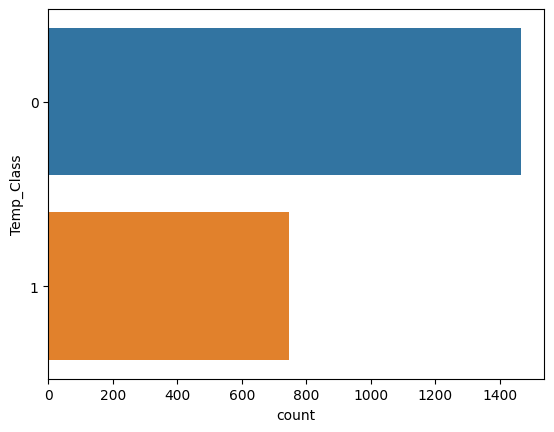

In [ ]:
sns.countplot(data=df_train_prepared, y="Temp_Class")

In [ ]:
X_train_rand, y_train_rand = do_rand(X_train, y_train)
X_train_smote, y_train_smote = do_smote(X_train, y_train)
X_train_bord, y_train_bord = do_bord(X_train, y_train)
X_train_adasyn, y_train_adasyn = do_adasyn(X_train, y_train)

##Model 1 (DecisionTreeClassifier)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
import sklearn
from sklearn.metrics import *
from sklearn.model_selection import GridSearchCV

In [ ]:
param_grid = {'max_depth': [4, 5, 6, 7, 8, 9, 10, 11, 12]}

### Random Oversampling

In [ ]:
clf_tree = DecisionTreeClassifier(random_state=2022)
grid = GridSearchCV(estimator=clf_tree,
                    param_grid=param_grid,
                    scoring="roc_auc",
                    n_jobs=-1)

grid.fit(X_train_rand, y_train_rand)
print(grid.best_score_)
print(grid.best_estimator_.max_depth)

0.7961297049598236
5


In [ ]:
opt_clf_tree = DecisionTreeClassifier(max_depth=grid.best_estimator_.max_depth, random_state=2022)
opt_clf_tree.fit(X_train_rand, y_train_rand)

y_train_opt_clf_tree = opt_clf_tree.predict(X_train_rand)
y_val_opt_clf_tree = opt_clf_tree.predict(X_val)

print(classification_report(y_train_rand, y_train_opt_clf_tree, target_names=["Temp < 20", "Temp >= 20"]))
print(classification_report(y_val, y_val_opt_clf_tree, target_names=["Temp < 20", "Temp >= 20"]))


y_train_opt_clf_tree_prob = opt_clf_tree.predict_proba(X_train_rand)
y_val_opt_clf_tree_prob = opt_clf_tree.predict_proba(X_val)


print(f"ROC AUC Score Train: {roc_auc_score(y_train_rand, y_train_opt_clf_tree_prob[:, 1]) * 100:.4f} %")
print(f"ROC AUC Score Val: {roc_auc_score(y_val, y_val_opt_clf_tree_prob[:, 1]) * 100:.4f} %")

              precision    recall  f1-score   support

   Temp < 20       0.80      0.94      0.86      1464
  Temp >= 20       0.92      0.76      0.83      1464

    accuracy                           0.85      2928
   macro avg       0.86      0.85      0.85      2928
weighted avg       0.86      0.85      0.85      2928

              precision    recall  f1-score   support

   Temp < 20       0.64      1.00      0.78       341
  Temp >= 20       1.00      0.09      0.17       212

    accuracy                           0.65       553
   macro avg       0.82      0.55      0.48       553
weighted avg       0.78      0.65      0.55       553

ROC AUC Score Train: 92.5730 %
ROC AUC Score Val: 39.4857 %


### SMOTE - Synthetic Minority Over-sampling Technique

In [ ]:
clf_tree = DecisionTreeClassifier(random_state=2022)
grid = GridSearchCV(estimator=clf_tree,
                    param_grid=param_grid,
                    scoring="roc_auc",
                    n_jobs=-1)

grid.fit(X_train_smote, y_train_smote)
print(grid.best_score_)
print(grid.best_estimator_.max_depth)

0.758966089232496
6


In [ ]:
opt_clf_tree = DecisionTreeClassifier(max_depth=grid.best_estimator_.max_depth, random_state=2022)
opt_clf_tree.fit(X_train_smote, y_train_smote)

y_train_opt_clf_tree = opt_clf_tree.predict(X_train_smote)
y_val_opt_clf_tree = opt_clf_tree.predict(X_val)

print(classification_report(y_train_smote, y_train_opt_clf_tree, target_names=["Temp < 20", "Temp >= 20"]))
print(classification_report(y_val, y_val_opt_clf_tree, target_names=["Temp < 20", "Temp >= 20"]))


y_train_opt_clf_tree_prob = opt_clf_tree.predict_proba(X_train_smote)
y_val_opt_clf_tree_prob = opt_clf_tree.predict_proba(X_val)


print(f"ROC AUC Score Train: {roc_auc_score(y_train_smote, y_train_opt_clf_tree_prob[:, 1]) * 100:.4f} %")
print(f"ROC AUC Score Val: {roc_auc_score(y_val, y_val_opt_clf_tree_prob[:, 1]) * 100:.4f} %")

              precision    recall  f1-score   support

   Temp < 20       0.89      0.92      0.90      1464
  Temp >= 20       0.92      0.88      0.90      1464

    accuracy                           0.90      2928
   macro avg       0.90      0.90      0.90      2928
weighted avg       0.90      0.90      0.90      2928

              precision    recall  f1-score   support

   Temp < 20       0.67      0.97      0.79       341
  Temp >= 20       0.84      0.23      0.36       212

    accuracy                           0.69       553
   macro avg       0.76      0.60      0.58       553
weighted avg       0.74      0.69      0.63       553

ROC AUC Score Train: 95.9693 %
ROC AUC Score Val: 43.2420 %


### Borderline SMOTE

In [ ]:
clf_tree = DecisionTreeClassifier(random_state=2022)
grid = GridSearchCV(estimator=clf_tree,
                    param_grid=param_grid,
                    scoring="roc_auc",
                    n_jobs=-1)

grid.fit(X_train_bord, y_train_bord)
print(grid.best_score_)
print(grid.best_estimator_.max_depth)

0.7560027386409748
6


In [ ]:
opt_clf_tree = DecisionTreeClassifier(max_depth=grid.best_estimator_.max_depth, random_state=2022)
opt_clf_tree.fit(X_train_bord, y_train_bord)

y_train_opt_clf_tree = opt_clf_tree.predict(X_train_bord)
y_val_opt_clf_tree = opt_clf_tree.predict(X_val)

print(classification_report(y_train_bord, y_train_opt_clf_tree, target_names=["Temp < 20", "Temp >= 20"]))
print(classification_report(y_val, y_val_opt_clf_tree, target_names=["Temp < 20", "Temp >= 20"]))


y_train_opt_clf_tree_prob = opt_clf_tree.predict_proba(X_train_bord)
y_val_opt_clf_tree_prob = opt_clf_tree.predict_proba(X_val)


print(f"ROC AUC Score Train: {roc_auc_score(y_train_bord, y_train_opt_clf_tree_prob[:, 1]) * 100:.4f} %")
print(f"ROC AUC Score Val: {roc_auc_score(y_val, y_val_opt_clf_tree_prob[:, 1]) * 100:.4f} %")

              precision    recall  f1-score   support

   Temp < 20       0.92      0.87      0.90      1464
  Temp >= 20       0.88      0.92      0.90      1464

    accuracy                           0.90      2928
   macro avg       0.90      0.90      0.90      2928
weighted avg       0.90      0.90      0.90      2928

              precision    recall  f1-score   support

   Temp < 20       0.65      0.96      0.78       341
  Temp >= 20       0.73      0.17      0.27       212

    accuracy                           0.66       553
   macro avg       0.69      0.56      0.52       553
weighted avg       0.68      0.66      0.58       553

ROC AUC Score Train: 95.7013 %
ROC AUC Score Val: 49.1202 %


### Adaptive Synthetic (ADASYN) algorithm

In [ ]:
clf_tree = DecisionTreeClassifier(random_state=2022)
grid = GridSearchCV(estimator=clf_tree,
                    param_grid=param_grid,
                    scoring="roc_auc",
                    n_jobs=-1)

grid.fit(X_train_adasyn, y_train_adasyn)
print(grid.best_score_)
print(grid.best_estimator_.max_depth)

0.7516845136660737
7


In [ ]:
opt_clf_tree = DecisionTreeClassifier(max_depth=grid.best_estimator_.max_depth, random_state=2022)
opt_clf_tree.fit(X_train_adasyn, y_train_adasyn)

y_train_opt_clf_tree = opt_clf_tree.predict(X_train_adasyn)
y_val_opt_clf_tree = opt_clf_tree.predict(X_val)

print(classification_report(y_train_adasyn, y_train_opt_clf_tree, target_names=["Temp < 20", "Temp >= 20"]))
print(classification_report(y_val, y_val_opt_clf_tree, target_names=["Temp < 20", "Temp >= 20"]))


y_train_opt_clf_tree_prob = opt_clf_tree.predict_proba(X_train_adasyn)
y_val_opt_clf_tree_prob = opt_clf_tree.predict_proba(X_val)


print(f"ROC AUC Score Train: {roc_auc_score(y_train_adasyn, y_train_opt_clf_tree_prob[:, 1]) * 100:.4f} %")
print(f"ROC AUC Score Val: {roc_auc_score(y_val, y_val_opt_clf_tree_prob[:, 1]) * 100:.4f} %")

              precision    recall  f1-score   support

   Temp < 20       0.95      0.93      0.94      1464
  Temp >= 20       0.93      0.95      0.94      1452

    accuracy                           0.94      2916
   macro avg       0.94      0.94      0.94      2916
weighted avg       0.94      0.94      0.94      2916

              precision    recall  f1-score   support

   Temp < 20       0.84      0.71      0.77       341
  Temp >= 20       0.63      0.78      0.69       212

    accuracy                           0.74       553
   macro avg       0.73      0.75      0.73       553
weighted avg       0.76      0.74      0.74       553

ROC AUC Score Train: 98.1003 %
ROC AUC Score Val: 72.5620 %


##Model 2 (Random Forest)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
clf_rand = RandomForestClassifier(random_state=2022)

In [ ]:
param_grid = {
    'n_estimators': [100,200],
    'max_depth': [5, 6, 7, 8, 9, 10, 11, 12],
    'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10],
    'max_features': ["auto", "sqrt", "log2"]}

In [ ]:
grid = GridSearchCV(estimator=clf_rand,
                    param_grid=param_grid,
                    scoring="roc_auc",
                    cv=cv_ls,
                    n_jobs=-1)

grid.fit(X_train_adasyn, y_train_adasyn)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan]
  warnings.warn(


GridSearchCV(cv=[(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108...
       2871, 2872, 2873, 2874, 2875, 2876, 2877, 2878, 2879, 2880, 2881,
       2882, 2883, 2884, 2885, 2886, 2887, 2888, 2889, 2890, 2891, 2892,
       2893, 2894, 2895, 2896, 2897, 2898, 2899, 2900, 2901, 2902, 2903,
       2904, 2905, 2906, 2907, 2908, 2909, 2910, 2911, 2912, 2913, 2914,
       2915]))],
             estimator=RandomForestClassifier(random_state=2022), n_jobs=-1,
             param_grid={'max_depth': [4, 5, 6, 7, 8, 9, 10, 11, 12]},
             scoring='roc_auc')

In [ ]:
print(grid.best_score_)
print(grid.best_estimator_)

nan
RandomForestClassifier(max_depth=4, random_state=2022)


In [ ]:
opt_clf_rand = RandomForestClassifier(max_depth=4, random_state=2022)
opt_clf_rand.fit(X_train_adasyn, y_train_adasyn)

RandomForestClassifier(max_depth=4, random_state=2022)

In [ ]:
y_train_opt_clf_rand = opt_clf_rand.predict(X_train_adasyn)
y_val_opt_clf_rand = opt_clf_rand.predict(X_val)

print(classification_report(y_train_adasyn, y_train_opt_clf_rand, target_names=["Temp < 20", "Temp >= 20"]))
print(classification_report(y_val, y_val_opt_clf_rand, target_names=["Temp < 20", "Temp >= 20"]))


y_train_opt_clf_rand_prob = opt_clf_rand.predict_proba(X_train_adasyn)
y_val_opt_clf_rand_prob = opt_clf_rand.predict_proba(X_val)


print(f"ROC AUC Score Train: {roc_auc_score(y_train_adasyn, y_train_opt_clf_rand_prob[:, 1]) * 100:.4f} %")
print(f"ROC AUC Score Val: {roc_auc_score(y_val, y_val_opt_clf_rand_prob[:, 1]) * 100:.4f} %")

              precision    recall  f1-score   support

   Temp < 20       0.90      0.88      0.89      1464
  Temp >= 20       0.88      0.90      0.89      1452

    accuracy                           0.89      2916
   macro avg       0.89      0.89      0.89      2916
weighted avg       0.89      0.89      0.89      2916

              precision    recall  f1-score   support

   Temp < 20       0.73      0.85      0.78       341
  Temp >= 20       0.67      0.48      0.56       212

    accuracy                           0.71       553
   macro avg       0.70      0.67      0.67       553
weighted avg       0.70      0.71      0.70       553

ROC AUC Score Train: 96.0259 %
ROC AUC Score Val: 81.6418 %


##Model 3 (Logistic Regression

In [ ]:
#Split with time series
cv_ls_rand = generate_list_timeseries_cv(X_train_rand)
cv_ls_smote = generate_list_timeseries_cv(X_train_smote)
cv_ls_bord = generate_list_timeseries_cv(X_train_bord)
cv_ls_ada = generate_list_timeseries_cv(X_train_adasyn)

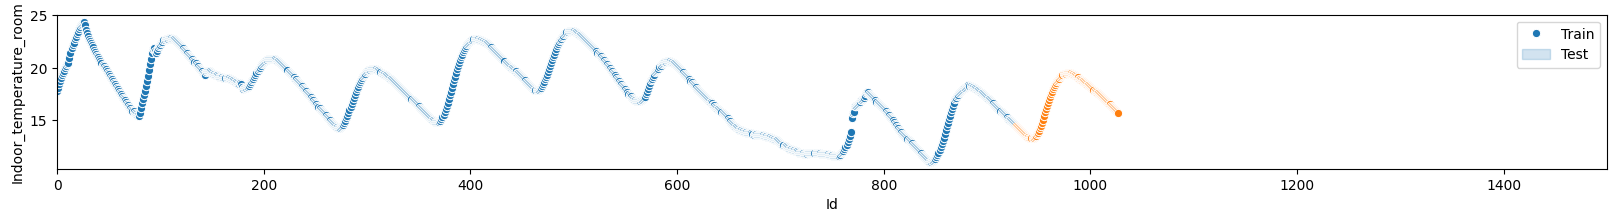

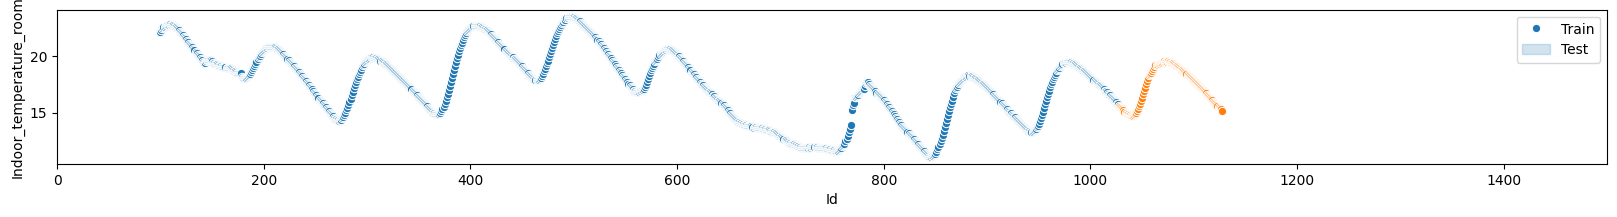

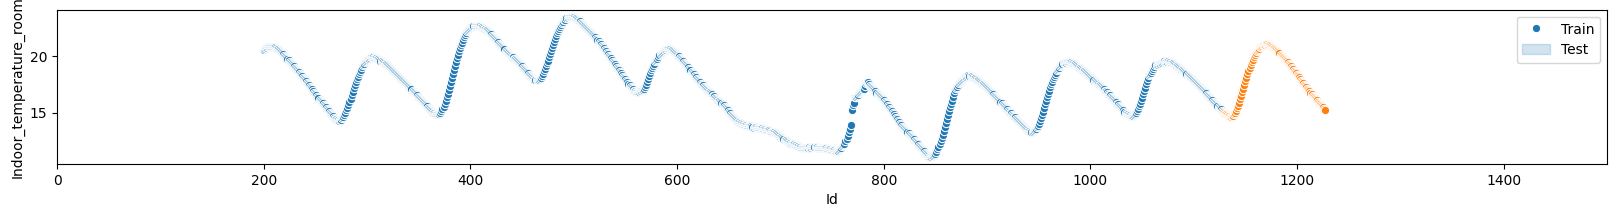

In [ ]:
plt.figure(figsize=(20, 2))
sns.lineplot(data=df_train_prepared.iloc[cv_ls_rand[0][0]], x="Id", y="Indoor_temperature_room", marker='o', linestyle='')
sns.lineplot(data=df_train_prepared.iloc[cv_ls_rand[0][1]], x="Id", y="Indoor_temperature_room", marker='o', linestyle='')
plt.xlim(0, 1500)
plt.legend(["Train", "Test"])

plt.figure(figsize=(20, 2))
sns.lineplot(data=df_train_prepared.iloc[cv_ls_rand[1][0]], x="Id", y="Indoor_temperature_room", marker='o', linestyle='')
sns.lineplot(data=df_train_prepared.iloc[cv_ls_rand[1][1]], x="Id", y="Indoor_temperature_room", marker='o', linestyle='')
plt.xlim(0, 1500)
plt.legend(["Train", "Test"])

plt.figure(figsize=(20, 2))
sns.lineplot(data=df_train_prepared.iloc[cv_ls_rand[2][0]], x="Id", y="Indoor_temperature_room", marker='o', linestyle='')
sns.lineplot(data=df_train_prepared.iloc[cv_ls_rand[2][1]], x="Id", y="Indoor_temperature_room", marker='o', linestyle='')
plt.xlim(0, 1500)
plt.legend(["Train", "Test"])

In [ ]:
from sklearn.linear_model import LogisticRegression
import sklearn
from sklearn.metrics import *
from sklearn.model_selection import GridSearchCV

In [ ]:
param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'C': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10],
    'solver': ['saga'],
    'l1_ratio': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1]
}

### Random Oversampling

In [ ]:
clf_log = LogisticRegression(random_state=2022, multi_class='ovr', n_jobs=-1)
grid = GridSearchCV(estimator=clf_log,
                    param_grid=param_grid,
                    scoring="f1",
                    cv=cv_ls_rand,
                    n_jobs=-1)

grid.fit(X_train_rand, y_train_rand)
print(grid.best_score_)

0.6194419358356447


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


In [ ]:
print(grid.best_params_)

{'C': 1e-05, 'l1_ratio': 1e-05, 'penalty': 'l1', 'solver': 'saga'}


In [ ]:
opt_clf_log = LogisticRegression(**grid.best_params_, random_state=2022, n_jobs=-1)
opt_clf_log.fit(X_train_rand, y_train_rand)

y_train_opt_clf_log = opt_clf_log.predict(X_train_rand)
y_val_opt_clf_log = opt_clf_log.predict(X_val)

print(classification_report(y_train_rand, y_train_opt_clf_log, target_names=["Temp < 20", "Temp >= 20"]))
print(classification_report(y_val, y_val_opt_clf_log, target_names=["Temp < 20", "Temp >= 20"]))


y_train_opt_clf_log_prob = opt_clf_log.predict_proba(X_train_rand)
y_val_opt_clf_log_prob = opt_clf_log.predict_proba(X_val)


print(f"ROC AUC Score Train: {roc_auc_score(y_train_rand, y_train_opt_clf_log_prob[:, 1]) * 100:.4f} %")
print(f"ROC AUC Score Val: {roc_auc_score(y_val, y_val_opt_clf_log_prob[:, 1]) * 100:.4f} %")

              precision    recall  f1-score   support

   Temp < 20       0.61      0.91      0.73      1464
  Temp >= 20       0.82      0.42      0.56      1464

    accuracy                           0.67      2928
   macro avg       0.72      0.67      0.65      2928
weighted avg       0.72      0.67      0.65      2928

              precision    recall  f1-score   support

   Temp < 20       0.71      0.88      0.78       341
  Temp >= 20       0.68      0.42      0.51       212

    accuracy                           0.70       553
   macro avg       0.69      0.65      0.65       553
weighted avg       0.70      0.70      0.68       553

ROC AUC Score Train: 72.6466 %
ROC AUC Score Val: 70.0271 %


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


### SMOTE - Synthetic Minority Over-sampling Technique

In [ ]:
clf_log = LogisticRegression(random_state=2022, multi_class='ovr', n_jobs=-1)
grid = GridSearchCV(estimator=clf_log,
                    param_grid=param_grid,
                    scoring="f1",
                    cv=cv_ls_smote,
                    n_jobs=-1)

grid.fit(X_train_smote, y_train_smote)
print(grid.best_score_)
print(grid.best_estimator_)

0.618461329498195
LogisticRegression(C=1e-05, l1_ratio=1e-05, multi_class='ovr', n_jobs=-1,
                   penalty='l1', random_state=2022, solver='saga')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


In [ ]:
opt_clf_log = LogisticRegression(**grid.best_params_, random_state=2022, n_jobs=-1)
opt_clf_log.fit(X_train_smote, y_train_smote)

y_train_opt_clf_log = opt_clf_log.predict(X_train_smote)
y_val_opt_clf_log = opt_clf_log.predict(X_val)

print(classification_report(y_train_smote, y_train_opt_clf_log, target_names=["Temp < 20", "Temp >= 20"]))
print(classification_report(y_val, y_val_opt_clf_log, target_names=["Temp < 20", "Temp >= 20"]))


y_train_opt_clf_log_prob = opt_clf_log.predict_proba(X_train_smote)
y_val_opt_clf_log_prob = opt_clf_log.predict_proba(X_val)


print(f"ROC AUC Score Train: {roc_auc_score(y_train_smote, y_train_opt_clf_log_prob[:, 1]) * 100:.4f} %")
print(f"ROC AUC Score Val: {roc_auc_score(y_val, y_val_opt_clf_log_prob[:, 1]) * 100:.4f} %")

              precision    recall  f1-score   support

   Temp < 20       0.62      0.91      0.74      1464
  Temp >= 20       0.83      0.43      0.57      1464

    accuracy                           0.67      2928
   macro avg       0.72      0.67      0.65      2928
weighted avg       0.72      0.67      0.65      2928

              precision    recall  f1-score   support

   Temp < 20       0.71      0.88      0.78       341
  Temp >= 20       0.68      0.42      0.51       212

    accuracy                           0.70       553
   macro avg       0.69      0.65      0.65       553
weighted avg       0.70      0.70      0.68       553

ROC AUC Score Train: 72.9360 %
ROC AUC Score Val: 70.0271 %


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


### Borderline SMOTE

In [ ]:
clf_log = LogisticRegression(random_state=2022, multi_class='ovr', n_jobs=-1)
grid = GridSearchCV(estimator=clf_log,
                    param_grid=param_grid,
                    scoring="f1",
                    cv=cv_ls_bord,
                    n_jobs=-1)

grid.fit(X_train_bord, y_train_bord)
print(grid.best_score_)
print(grid.best_estimator_)

0.6079167637899905
LogisticRegression(C=1e-05, l1_ratio=1e-05, multi_class='ovr', n_jobs=-1,
                   penalty='l1', random_state=2022, solver='saga')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


In [ ]:
opt_clf_log = LogisticRegression(**grid.best_params_, random_state=2022, n_jobs=-1)
opt_clf_log.fit(X_train_bord, y_train_bord)

y_train_opt_clf_log = opt_clf_log.predict(X_train_bord)
y_val_opt_clf_log = opt_clf_log.predict(X_val)

print(classification_report(y_train_bord, y_train_opt_clf_log, target_names=["Temp < 20", "Temp >= 20"]))
print(classification_report(y_val, y_val_opt_clf_log, target_names=["Temp < 20", "Temp >= 20"]))


y_train_opt_clf_log_prob = opt_clf_log.predict_proba(X_train_bord)
y_val_opt_clf_log_prob = opt_clf_log.predict_proba(X_val)


print(f"ROC AUC Score Train: {roc_auc_score(y_train_bord, y_train_opt_clf_log_prob[:, 1]) * 100:.4f} %")
print(f"ROC AUC Score Val: {roc_auc_score(y_val, y_val_opt_clf_log_prob[:, 1]) * 100:.4f} %")

              precision    recall  f1-score   support

   Temp < 20       0.60      0.90      0.72      1464
  Temp >= 20       0.80      0.40      0.54      1464

    accuracy                           0.65      2928
   macro avg       0.70      0.65      0.63      2928
weighted avg       0.70      0.65      0.63      2928

              precision    recall  f1-score   support

   Temp < 20       0.72      0.86      0.78       341
  Temp >= 20       0.67      0.45      0.54       212

    accuracy                           0.71       553
   macro avg       0.69      0.66      0.66       553
weighted avg       0.70      0.71      0.69       553

ROC AUC Score Train: 69.0985 %
ROC AUC Score Val: 71.3578 %


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


### Adaptive Synthetic (ADASYN) algorithm

In [ ]:
clf_log = LogisticRegression(random_state=2022, multi_class='ovr', n_jobs=-1)
grid = GridSearchCV(estimator=clf_log,
                    param_grid=param_grid,
                    scoring="f1",
                    cv=cv_ls_ada,
                    n_jobs=-1)

grid.fit(X_train_adasyn, y_train_adasyn)
print(grid.best_score_)
print(grid.best_estimator_)

0.6151497010731519
LogisticRegression(C=1e-05, l1_ratio=1e-05, multi_class='ovr', n_jobs=-1,
                   penalty='l1', random_state=2022, solver='saga')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


In [ ]:
opt_clf_log = LogisticRegression(**grid.best_params_, random_state=2022, n_jobs=-1)
opt_clf_log.fit(X_train_adasyn, y_train_adasyn)

y_train_opt_clf_log = opt_clf_log.predict(X_train_adasyn)
y_val_opt_clf_log = opt_clf_log.predict(X_val)

print(classification_report(y_train_adasyn, y_train_opt_clf_log, target_names=["Temp < 20", "Temp >= 20"]))
print(classification_report(y_val, y_val_opt_clf_log, target_names=["Temp < 20", "Temp >= 20"]))


y_train_opt_clf_log_prob = opt_clf_log.predict_proba(X_train_adasyn)
y_val_opt_clf_log_prob = opt_clf_log.predict_proba(X_val)


print(f"ROC AUC Score Train: {roc_auc_score(y_train_adasyn, y_train_opt_clf_log_prob[:, 1]) * 100:.4f} %")
print(f"ROC AUC Score Val: {roc_auc_score(y_val, y_val_opt_clf_log_prob[:, 1]) * 100:.4f} %")

              precision    recall  f1-score   support

   Temp < 20       0.64      0.90      0.75      1464
  Temp >= 20       0.82      0.49      0.61      1452

    accuracy                           0.69      2916
   macro avg       0.73      0.69      0.68      2916
weighted avg       0.73      0.69      0.68      2916

              precision    recall  f1-score   support

   Temp < 20       0.72      0.86      0.78       341
  Temp >= 20       0.67      0.46      0.55       212

    accuracy                           0.71       553
   macro avg       0.69      0.66      0.66       553
weighted avg       0.70      0.71      0.69       553

ROC AUC Score Train: 72.7630 %
ROC AUC Score Val: 71.5833 %


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


##Model 4 (KNN)




In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
param_grid_knn = {
    'p': [1, 2, 3, 4, 5],
    'n_neighbors': [5, 7, 9, 11]
}

### Random Oversampling

In [ ]:
clf_knn = KNeighborsClassifier()
grid = GridSearchCV(estimator=clf_knn,
                    param_grid=param_grid_knn,
                    scoring="f1",
                    cv=cv_ls_rand,
                    n_jobs=-1)

grid.fit(X_train_rand, y_train_rand)
print(grid.best_score_)
print(grid.best_estimator_)

0.6579367220657433
KNeighborsClassifier(n_neighbors=9)


In [ ]:
print(grid.best_params_)

{'n_neighbors': 9, 'p': 2}


In [ ]:
opt_clf_knn = KNeighborsClassifier(**grid.best_params_)
opt_clf_knn.fit(X_train_rand, y_train_rand)

y_train_opt_clf_knn = opt_clf_knn.predict(X_train_rand)
y_val_opt_clf_knn = opt_clf_knn.predict(X_val)

print(classification_report(y_train_rand, y_train_opt_clf_knn, target_names=["Temp < 20", "Temp >= 20"]))
print(classification_report(y_val, y_val_opt_clf_knn, target_names=["Temp < 20", "Temp >= 20"]))


y_train_opt_clf_knn_prob = opt_clf_knn.predict_proba(X_train_rand)
y_val_opt_clf_knn_prob = opt_clf_knn.predict_proba(X_val)


print(f"ROC AUC Score Train: {roc_auc_score(y_train_rand, y_train_opt_clf_knn_prob[:, 1]) * 100:.4f} %")
print(f"ROC AUC Score Val: {roc_auc_score(y_val, y_val_opt_clf_knn_prob[:, 1]) * 100:.4f} %")

              precision    recall  f1-score   support

   Temp < 20       0.93      0.85      0.89      1464
  Temp >= 20       0.86      0.94      0.90      1464

    accuracy                           0.89      2928
   macro avg       0.90      0.89      0.89      2928
weighted avg       0.90      0.89      0.89      2928

              precision    recall  f1-score   support

   Temp < 20       0.72      0.79      0.75       341
  Temp >= 20       0.59      0.50      0.55       212

    accuracy                           0.68       553
   macro avg       0.66      0.65      0.65       553
weighted avg       0.67      0.68      0.67       553

ROC AUC Score Train: 96.4238 %
ROC AUC Score Val: 66.4534 %


### SMOTE - Synthetic Minority Over-sampling Technique

In [ ]:
clf_knn = KNeighborsClassifier()
grid = GridSearchCV(estimator=clf_knn,
                    param_grid=param_grid_knn,
                    scoring="f1",
                    cv=cv_ls_smote,
                    n_jobs=-1)

grid.fit(X_train_smote, y_train_smote)
print(grid.best_score_)
print(grid.best_params_)

0.6598343176226292
{'n_neighbors': 9, 'p': 2}


In [ ]:
opt_clf_knn = KNeighborsClassifier(**grid.best_params_)
opt_clf_knn.fit(X_train_smote, y_train_smote)

y_train_opt_clf_knn = opt_clf_knn.predict(X_train_smote)
y_val_opt_clf_knn = opt_clf_knn.predict(X_val)

print(classification_report(y_train_smote, y_train_opt_clf_knn, target_names=["Temp < 20", "Temp >= 20"]))
print(classification_report(y_val, y_val_opt_clf_knn, target_names=["Temp < 20", "Temp >= 20"]))


y_train_opt_clf_knn_prob = opt_clf_knn.predict_proba(X_train_smote)
y_val_opt_clf_knn_prob = opt_clf_knn.predict_proba(X_val)


print(f"ROC AUC Score Train: {roc_auc_score(y_train_smote, y_train_opt_clf_knn_prob[:, 1]) * 100:.4f} %")
print(f"ROC AUC Score Val: {roc_auc_score(y_val, y_val_opt_clf_knn_prob[:, 1]) * 100:.4f} %")

              precision    recall  f1-score   support

   Temp < 20       0.95      0.85      0.90      1464
  Temp >= 20       0.87      0.96      0.91      1464

    accuracy                           0.91      2928
   macro avg       0.91      0.91      0.91      2928
weighted avg       0.91      0.91      0.91      2928

              precision    recall  f1-score   support

   Temp < 20       0.73      0.80      0.76       341
  Temp >= 20       0.61      0.52      0.56       212

    accuracy                           0.69       553
   macro avg       0.67      0.66      0.66       553
weighted avg       0.68      0.69      0.68       553

ROC AUC Score Train: 96.9518 %
ROC AUC Score Val: 67.1036 %


### Borderline SMOTE

In [ ]:
clf_knn = KNeighborsClassifier()
grid = GridSearchCV(estimator=clf_knn,
                    param_grid=param_grid_knn,
                    scoring="f1",
                    cv=cv_ls_bord,
                    n_jobs=-1)

grid.fit(X_train_bord, y_train_bord)
print(grid.best_score_)
print(grid.best_params_)

0.648219440974301
{'n_neighbors': 9, 'p': 2}


In [ ]:
opt_clf_knn = KNeighborsClassifier(**grid.best_params_)
opt_clf_knn.fit(X_train_bord, y_train_bord)

y_train_opt_clf_knn = opt_clf_knn.predict(X_train_bord)
y_val_opt_clf_knn = opt_clf_knn.predict(X_val)

print(classification_report(y_train_bord, y_train_opt_clf_knn, target_names=["Temp < 20", "Temp >= 20"]))
print(classification_report(y_val, y_val_opt_clf_knn, target_names=["Temp < 20", "Temp >= 20"]))


y_train_opt_clf_knn_prob = opt_clf_knn.predict_proba(X_train_bord)
y_val_opt_clf_knn_prob = opt_clf_knn.predict_proba(X_val)


print(f"ROC AUC Score Train: {roc_auc_score(y_train_bord, y_train_opt_clf_knn_prob[:, 1]) * 100:.4f} %")
print(f"ROC AUC Score Val: {roc_auc_score(y_val, y_val_opt_clf_knn_prob[:, 1]) * 100:.4f} %")

              precision    recall  f1-score   support

   Temp < 20       0.97      0.80      0.88      1464
  Temp >= 20       0.83      0.97      0.90      1464

    accuracy                           0.89      2928
   macro avg       0.90      0.89      0.89      2928
weighted avg       0.90      0.89      0.89      2928

              precision    recall  f1-score   support

   Temp < 20       0.72      0.74      0.73       341
  Temp >= 20       0.56      0.54      0.55       212

    accuracy                           0.66       553
   macro avg       0.64      0.64      0.64       553
weighted avg       0.66      0.66      0.66       553

ROC AUC Score Train: 95.8702 %
ROC AUC Score Val: 65.8904 %


### Adaptive Synthetic (ADASYN) algorithm

In [ ]:
clf_knn = KNeighborsClassifier()
grid = GridSearchCV(estimator=clf_knn,
                    param_grid=param_grid_knn,
                    scoring="f1",
                    cv=cv_ls_ada,
                    n_jobs=-1)

grid.fit(X_train_adasyn, y_train_adasyn)
print(grid.best_score_)
print(grid.best_params_)

0.6493163897300948
{'n_neighbors': 9, 'p': 2}


In [ ]:
opt_clf_knn = KNeighborsClassifier(**grid.best_params_)
opt_clf_knn.fit(X_train_adasyn, y_train_adasyn)

y_train_opt_clf_knn = opt_clf_knn.predict(X_train_adasyn)
y_val_opt_clf_knn = opt_clf_knn.predict(X_val)

print(classification_report(y_train_adasyn, y_train_opt_clf_knn, target_names=["Temp < 20", "Temp >= 20"]))
print(classification_report(y_val, y_val_opt_clf_knn, target_names=["Temp < 20", "Temp >= 20"]))


y_train_opt_clf_knn_prob = opt_clf_knn.predict_proba(X_train_adasyn)
y_val_opt_clf_knn_prob = opt_clf_knn.predict_proba(X_val)


print(f"ROC AUC Score Train: {roc_auc_score(y_train_adasyn, y_train_opt_clf_knn_prob[:, 1]) * 100:.4f} %")
print(f"ROC AUC Score Val: {roc_auc_score(y_val, y_val_opt_clf_knn_prob[:, 1]) * 100:.4f} %")

              precision    recall  f1-score   support

   Temp < 20       0.95      0.81      0.88      1464
  Temp >= 20       0.83      0.96      0.89      1452

    accuracy                           0.88      2916
   macro avg       0.89      0.88      0.88      2916
weighted avg       0.89      0.88      0.88      2916

              precision    recall  f1-score   support

   Temp < 20       0.72      0.74      0.73       341
  Temp >= 20       0.56      0.54      0.55       212

    accuracy                           0.66       553
   macro avg       0.64      0.64      0.64       553
weighted avg       0.66      0.66      0.66       553

ROC AUC Score Train: 95.5086 %
ROC AUC Score Val: 66.2383 %


## Conclusion Classification


| Rank | Model                                      | ROC AUC Score Val |
|------|--------------------------------------------|------------------:|
| 1    | RandomForest (ADASYN)                      |           81.641% |
| 2    | DecisionTree (ADASYN)                      |           72.562% |
| 3    | Logistic Regression (ADASYN)               |           71.583% |
| 4    | Logistic Regression (Borderline SMOTE)     |           71.357% |
| 5    | Logistic Regression (Random oversampling)  |           70.027% |
| 6    | Logistic Regression (SMOTE)                |           70.027% |
| 7    | KNN (SMOTE)                                |           67.103% |
| 8    | KNN (Random oversampling)                  |           66.453% |
| 9    | KNN (Borderline SMOTE)                     |           65.890% |
| 10   | KNN (ADASYN)                               |           66.238 %  |
| 11   | DecisionTree (Borderline SMOTE)            |           49.120% |
| 12   | DecisionTree (SMOTE)                       |           43.242% |
| 13   | DecisionTree (Random oversampling)         |           39.486% |


Overall, the RandomForest model with ADASYN oversampling demonstrated the highest performance, followed by the DecisionTree (ADASYN) and Logistic Regression models with different oversampling techniques. The KNN models performed moderately well, while the DecisionTree models had the lowest performance among the evaluated models.

## Custom Scoring (Logistic Regression)

### Define Logic of Cost Function

In [ ]:
0 -> temp < 20
1 -> temp >= 20

basis
0 -> negative
1 -> positive

get score
true 0 predict 0 -> acc 1 (true negative) | cost -> 0
true 1 predict 1 -> acc 1 (true positive) | cost -> 0

get penalty
true 0 predict 1 -> acc 0 (false positive) | cost -> 100
true 1 predict 0 -> acc 0 (false negative) | cost -> 0

In [ ]:
def cost_electricity(y_trues, y_preds):
  """
  This function defines the logic of the cost function.

  Args:
    y_true: A list of ground truth labels.
    y_pred: A list of predicted labels.

  Returns:
    The cost of the model.
  """

  # Get the number of samples.
  num_samples = len(y_trues)

  # Initialize the cost to 0.
  cost = 0

  # Iterate over all samples.
  for i in range(num_samples):
    # If the ground truth label is 0 and the predicted label is 1, then the cost is 100.
    if y_trues[i] == 0 and y_preds[i] == 1:
      cost += 100

    # If the ground truth label is 1 and the predicted label is 0, then the cost is 0.
    elif y_trues[i] == 1 and y_preds[i] == 0:
      cost += 0

    # Otherwise, the cost is 0.
    else:
      cost += 0

  # Return the cost.
  return cost


In [ ]:
def avg_f1(y_trues, y_preds):
    avg_f1 = (f1_score(y_trues, y_preds, pos_label=0) + f1_score(y_trues, y_preds, pos_label=1))/2
    return avg_f1

In [ ]:
score_cost_electricity = make_scorer(cost_electricity, greater_is_better=False)
score_avg_f1 = make_scorer(avg_f1, greater_is_better=True)

### Random Oversampling

In [ ]:
clf_log = LogisticRegression(random_state=2022, multi_class='ovr', n_jobs=-1)
grid = GridSearchCV(estimator=clf_log,
                    param_grid=param_grid,
                    scoring=score_cost_electricity,
                    cv=cv_ls_rand,
                    n_jobs=-1)

grid.fit(X_train_rand, y_train_rand)
print(grid.best_score_)
print(grid.best_params_)

-140.0
{'C': 1e-05, 'l1_ratio': 1e-05, 'penalty': 'l1', 'solver': 'saga'}


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


In [ ]:
opt_clf_log = LogisticRegression(**grid.best_params_, random_state=2022, n_jobs=-1)
opt_clf_log.fit(X_train_rand, y_train_rand)

y_train_opt_clf_log = opt_clf_log.predict(X_train_rand)
y_val_opt_clf_log = opt_clf_log.predict(X_val)

print(classification_report(y_train_rand, y_train_opt_clf_log, target_names=["Temp < 20", "Temp >= 20"]))
print(classification_report(y_val, y_val_opt_clf_log, target_names=["Temp < 20", "Temp >= 20"]))


y_train_opt_clf_log_prob = opt_clf_log.predict_proba(X_train_rand)
y_val_opt_clf_log_prob = opt_clf_log.predict_proba(X_val)

print(f"AVG Electricity Cost Train: {cost_electricity(y_train_rand, y_train_opt_clf_log)/len(y_train_rand):.4f} Baht")
print(f"AVG Electricity Cost Val: {cost_electricity(y_val, y_val_opt_clf_log)/len(y_val):.4f} Baht")

print(f"AVG F1 Score Train: {avg_f1(y_train_rand, y_train_opt_clf_log)*100:.4f} %")
print(f"AVG F1 Score Val: {avg_f1(y_val, y_val_opt_clf_log)*100:.4f} %")

print(f"ROC AUC Score Train: {roc_auc_score(y_train_rand, y_train_opt_clf_log_prob[:, 1]) * 100:.4f} %")
print(f"ROC AUC Score Val: {roc_auc_score(y_val, y_val_opt_clf_log_prob[:, 1]) * 100:.4f} %")

              precision    recall  f1-score   support

   Temp < 20       0.61      0.91      0.73      1464
  Temp >= 20       0.82      0.42      0.56      1464

    accuracy                           0.67      2928
   macro avg       0.72      0.67      0.65      2928
weighted avg       0.72      0.67      0.65      2928

              precision    recall  f1-score   support

   Temp < 20       0.71      0.88      0.78       341
  Temp >= 20       0.68      0.42      0.51       212

    accuracy                           0.70       553
   macro avg       0.69      0.65      0.65       553
weighted avg       0.70      0.70      0.68       553

AVG Electricity Cost Train: 4.5082 Baht
AVG Electricity Cost Val: 7.5949 Baht
AVG F1 Score Train: 64.6568 %
AVG F1 Score Val: 64.8671 %
ROC AUC Score Train: 72.6466 %
ROC AUC Score Val: 70.0271 %


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


###SMOTE

In [ ]:
clf_log = LogisticRegression(random_state=2022, multi_class='ovr', n_jobs=-1)
grid = GridSearchCV(estimator=clf_log,
                    param_grid=param_grid,
                    scoring=score_cost_electricity,
                    cv=cv_ls_smote,
                    n_jobs=-1)

grid.fit(X_train_smote, y_train_smote)
print(grid.best_score_)
print(grid.best_estimator_)

-140.0
LogisticRegression(C=1e-05, l1_ratio=1e-05, multi_class='ovr', n_jobs=-1,
                   penalty='l1', random_state=2022, solver='saga')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


In [ ]:
opt_clf_log = LogisticRegression(**grid.best_params_, random_state=2022, n_jobs=-1)
opt_clf_log.fit(X_train_smote, y_train_smote)

y_train_opt_clf_log = opt_clf_log.predict(X_train_smote)
y_val_opt_clf_log = opt_clf_log.predict(X_val)

print(classification_report(y_train_smote, y_train_opt_clf_log, target_names=["Temp < 20", "Temp >= 20"]))
print(classification_report(y_val, y_val_opt_clf_log, target_names=["Temp < 20", "Temp >= 20"]))


y_train_opt_clf_log_prob = opt_clf_log.predict_proba(X_train_smote)
y_val_opt_clf_log_prob = opt_clf_log.predict_proba(X_val)

print(f"AVG Electricity Cost Train: {cost_electricity(y_train_smote, y_train_opt_clf_log)/len(y_train_smote):.4f} Baht")
print(f"AVG Electricity Cost Val: {cost_electricity(y_val, y_val_opt_clf_log)/len(y_val):.4f} Baht")

print(f"AVG F1 Score Train: {avg_f1(y_train_smote, y_train_opt_clf_log)*100:.4f} %")
print(f"AVG F1 Score Val: {avg_f1(y_val, y_val_opt_clf_log)*100:.4f} %")

print(f"ROC AUC Score Train: {roc_auc_score(y_train_rand, y_train_opt_clf_log_prob[:, 1]) * 100:.4f} %")
print(f"ROC AUC Score Val: {roc_auc_score(y_val, y_val_opt_clf_log_prob[:, 1]) * 100:.4f} %")

              precision    recall  f1-score   support

   Temp < 20       0.62      0.91      0.74      1464
  Temp >= 20       0.83      0.43      0.57      1464

    accuracy                           0.67      2928
   macro avg       0.72      0.67      0.65      2928
weighted avg       0.72      0.67      0.65      2928

              precision    recall  f1-score   support

   Temp < 20       0.71      0.88      0.78       341
  Temp >= 20       0.68      0.42      0.51       212

    accuracy                           0.70       553
   macro avg       0.69      0.65      0.65       553
weighted avg       0.70      0.70      0.68       553

AVG Electricity Cost Train: 4.4740 Baht
AVG Electricity Cost Val: 7.5949 Baht
AVG F1 Score Train: 65.1954 %
AVG F1 Score Val: 64.8671 %
ROC AUC Score Train: 72.9360 %
ROC AUC Score Val: 70.0271 %


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


###Borderline SMOTE

In [ ]:
clf_log = LogisticRegression(random_state=2022, multi_class='ovr', n_jobs=-1)
grid = GridSearchCV(estimator=clf_log,
                    param_grid=param_grid,
                    scoring=score_cost_electricity,
                    cv=cv_ls_bord,
                    n_jobs=-1)

grid.fit(X_train_bord, y_train_bord)
print(grid.best_score_)
print(grid.best_estimator_)

-140.0
LogisticRegression(C=1e-05, l1_ratio=1e-05, multi_class='ovr', n_jobs=-1,
                   penalty='l1', random_state=2022, solver='saga')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


In [ ]:
opt_clf_log = LogisticRegression(**grid.best_params_, random_state=2022, n_jobs=-1)
opt_clf_log.fit(X_train_bord, y_train_bord)

y_train_opt_clf_log = opt_clf_log.predict(X_train_bord)
y_val_opt_clf_log = opt_clf_log.predict(X_val)

print(classification_report(y_train_bord, y_train_opt_clf_log, target_names=["Temp < 20", "Temp >= 20"]))
print(classification_report(y_val, y_val_opt_clf_log, target_names=["Temp < 20", "Temp >= 20"]))


y_train_opt_clf_log_prob = opt_clf_log.predict_proba(X_train_bord)
y_val_opt_clf_log_prob = opt_clf_log.predict_proba(X_val)

print(f"AVG Electricity Cost Train: {cost_electricity(y_train_bord, y_train_opt_clf_log)/len(y_train_bord):.4f} Baht")
print(f"AVG Electricity Cost Val: {cost_electricity(y_val, y_val_opt_clf_log)/len(y_val):.4f} Baht")

print(f"AVG F1 Score Train: {avg_f1(y_train_bord, y_train_opt_clf_log)*100:.4f} %")
print(f"AVG F1 Score Val: {avg_f1(y_val, y_val_opt_clf_log)*100:.4f} %")

print(f"ROC AUC Score Train: {roc_auc_score(y_train_rand, y_train_opt_clf_log_prob[:, 1]) * 100:.4f} %")
print(f"ROC AUC Score Val: {roc_auc_score(y_val, y_val_opt_clf_log_prob[:, 1]) * 100:.4f} %")

              precision    recall  f1-score   support

   Temp < 20       0.60      0.90      0.72      1464
  Temp >= 20       0.80      0.40      0.54      1464

    accuracy                           0.65      2928
   macro avg       0.70      0.65      0.63      2928
weighted avg       0.70      0.65      0.63      2928

              precision    recall  f1-score   support

   Temp < 20       0.72      0.86      0.78       341
  Temp >= 20       0.67      0.45      0.54       212

    accuracy                           0.71       553
   macro avg       0.69      0.66      0.66       553
weighted avg       0.70      0.71      0.69       553

AVG Electricity Cost Train: 4.9863 Baht
AVG Electricity Cost Val: 8.4991 Baht
AVG F1 Score Train: 62.9116 %
AVG F1 Score Val: 66.1901 %
ROC AUC Score Train: 69.0985 %
ROC AUC Score Val: 71.3578 %


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


###ADASYN

In [ ]:
clf_log = LogisticRegression(random_state=2022, multi_class='ovr', n_jobs=-1)
grid = GridSearchCV(estimator=clf_log,
                    param_grid=param_grid,
                    scoring=score_cost_electricity,
                    cv=cv_ls_ada,
                    n_jobs=-1)

grid.fit(X_train_adasyn, y_train_adasyn)
print(grid.best_score_)
print(grid.best_estimator_)

-130.0
LogisticRegression(C=1e-05, l1_ratio=1e-05, multi_class='ovr', n_jobs=-1,
                   penalty='l1', random_state=2022, solver='saga')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


In [ ]:
opt_clf_log = LogisticRegression(**grid.best_params_, random_state=2022, n_jobs=-1)
opt_clf_log.fit(X_train_adasyn, y_train_adasyn)

y_train_opt_clf_log = opt_clf_log.predict(X_train_adasyn)
y_val_opt_clf_log = opt_clf_log.predict(X_val)

print(classification_report(y_train_adasyn, y_train_opt_clf_log, target_names=["Temp < 20", "Temp >= 20"]))
print(classification_report(y_val, y_val_opt_clf_log, target_names=["Temp < 20", "Temp >= 20"]))


y_train_opt_clf_log_prob = opt_clf_log.predict_proba(X_train_adasyn)
y_val_opt_clf_log_prob = opt_clf_log.predict_proba(X_val)

print(f"AVG Electricity Cost Train: {cost_electricity(y_train_adasyn, y_train_opt_clf_log)/len(y_train_adasyn):.4f} Baht")
print(f"AVG Electricity Cost Val: {cost_electricity(y_val, y_val_opt_clf_log)/len(y_val):.4f} Baht")

print(f"AVG F1 Score Train: {avg_f1(y_train_adasyn, y_train_opt_clf_log)*100:.4f} %")
print(f"AVG F1 Score Val: {avg_f1(y_val, y_val_opt_clf_log)*100:.4f} %")

print(f"ROC AUC Score Train: {roc_auc_score(y_train_adasyn, y_train_opt_clf_log_prob[:, 1]) * 100:.4f} %")
print(f"ROC AUC Score Val: {roc_auc_score(y_val, y_val_opt_clf_log_prob[:, 1]) * 100:.4f} %")

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


              precision    recall  f1-score   support

   Temp < 20       0.64      0.90      0.75      1464
  Temp >= 20       0.82      0.49      0.61      1452

    accuracy                           0.69      2916
   macro avg       0.73      0.69      0.68      2916
weighted avg       0.73      0.69      0.68      2916

              precision    recall  f1-score   support

   Temp < 20       0.72      0.86      0.78       341
  Temp >= 20       0.67      0.46      0.55       212

    accuracy                           0.71       553
   macro avg       0.69      0.66      0.66       553
weighted avg       0.70      0.71      0.69       553

AVG Electricity Cost Train: 5.1783 Baht
AVG Electricity Cost Val: 8.8608 Baht
AVG F1 Score Train: 67.9266 %
AVG F1 Score Val: 66.3877 %
ROC AUC Score Train: 72.7630 %
ROC AUC Score Val: 71.5833 %


##Conclusion Custom scoring


| Technique       | AVG Electricity Cost Train | AVG Electricity Cost Val | AVG F1 Score Train | AVG F1 Score Val | ROC AUC Score Train | ROC AUC Score Val |
|-----------------|---------------------------|-------------------------|--------------------|------------------|---------------------|-------------------|
| Random oversampling | 4.5082 Baht | 7.5949 Baht | 64.6568% | 64.8671% | 72.6466% | 70.0271% |
| SMOTE           | 4.4740 Baht                | 7.5949 Baht             | 65.1954%           | 64.8671%         | 72.9360%                | 70.0271%             |
| Borderline SMOTE | 4.9863 Baht                | 8.4991 Baht             | 62.9116%           | 66.1901%         | 69.0985%                | 71.3578%             |
| ADASYN          | 5.1783 Baht                | 8.8608 Baht             | 67.9266%           | 66.3877%         | 72.7630%                | 71.5833%             |

Considering the focus on lower costs, the Random oversampling and SMOTE techniques appear to be more favorable choices, as they have lower average electricity costs compared to Borderline SMOTE and ADASYN.

## Model 5  (LGBM with Optuna)

In [ ]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 8.6 MB/s eta 0:00:00


In [ ]:
!pip install lightgbm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import lightgbm as lgb
import optuna

In [ ]:
def objective(trial):
    params = {
        'metric': 'logloss',
        'random_state': 42,
        'n_estimators': 300,
        'learning_rate': 0.1,
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'max_depth': trial.suggest_categorical('max_depth', [10,20,30,40,50]),
        'num_leaves' : trial.suggest_int('num_leaves', 1, 100),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
        'cat_smooth' : trial.suggest_int('cat_smooth', 1, 100)
    }
    model = lgb.LGBMClassifier(**params)

    model.fit(X_train, y_train)

    y_val_pred = model.predict(X_val)
    cost = cost_electricity(y_val, y_val_pred)

    return cost

In [ ]:
#Discretize label columns
df_train["Temp_Class"] = get_classs_temps(df_train["Indoor_temperature_room"].values)

In [ ]:
df_train["Temp_Class"].value_counts(normalize=True)

0    0.653039
1    0.346961
Name: Temp_Class, dtype: float64

In [ ]:
#Define features columns
FEATURES_COLUMNS = [
    "CO2_room",
    "Relative_humidity_room",
    "Meteo_Sun_irradiance",
    'Meteo_Rain',
    'Meteo_Sun_dusk',
    'Meteo_Wind',
    'Meteo_Sun_light_in_west_facade',
    'Meteo_Sun_light_in_east_facade',
    'Outdoor_relative_humidity_Sensor',
    'Day_of_the_week'
]

In [ ]:
#Define X_train,X_val,y_train,y_val
df_train_prepared, df_valid_prepared = split_train_test2(df_train, FEATURES_COLUMNS, train_size=0.8)
print(f"Train shape: {df_train_prepared.shape}")
print(f"Val shape: {df_valid_prepared.shape}")

X_train = df_train_prepared[FEATURES_COLUMNS].values
X_val = df_valid_prepared[FEATURES_COLUMNS].values

y_train = df_train_prepared["Temp_Class"].values
y_val = df_valid_prepared["Temp_Class"].values

print(f"X Train shape: {X_train.shape}")
print(f"X Val shape: {X_val.shape}")
print(f"Y Train shape: {y_train.shape}")
print(f"Y Val shape: {y_val.shape}")

Train shape: (2211, 13)
Val shape: (553, 13)
X Train shape: (2211, 10)
X Val shape: (553, 10)
Y Train shape: (2211,)
Y Val shape: (553,)


In [ ]:
find_params = True
if find_params:
    study = optuna.create_study(
        direction='minimize',
        pruner=optuna.pruners.MedianPruner(n_warmup_steps=20),
        study_name='small')
    study.optimize(objective, n_trials=20)

[I 2023-06-15 04:09:40,463] A new study created in memory with name: small
<ipython-input-20-446c122f5b50>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
<ipython-input-20-446c122f5b50>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
[I 2023-06-15 04:09:40,642] Trial 0 finished with value: 3400.0 and parameters: {'reg_alpha': 0.21903653570769155, 'reg_lambda': 0.027589027811189937, 'colsample_bytree': 0.5, 'subsample': 1.0, 'max_depth': 40, 'num_leaves': 87, 'min_child_samples': 128, 'cat_smooth': 66}. Best is trial 0 with value: 3400.0.
<

In [ ]:
study.best_params

{'reg_alpha': 0.0027427490923823744,
 'reg_lambda': 1.737592657955828,
 'colsample_bytree': 0.9,
 'subsample': 0.6,
 'max_depth': 40,
 'num_leaves': 77,
 'min_child_samples': 1,
 'cat_smooth': 25}

In [ ]:
best_params = study.best_params

In [ ]:
fixed_params = {
    'metric': 'logloss',
    'random_state': 42,
    'n_estimators': 300,
    'learning_rate': 0.1,
}

In [ ]:
merged_params = {
    **best_params, **fixed_params
}

In [ ]:
model = lgb.LGBMClassifier(**merged_params)
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)

cost_train = cost_electricity(y_train, y_train_pred) / len(y_train)
cost_val = cost_electricity(y_val, y_val_pred) / len(y_val)

y_train_model_prob = model.predict_proba(X_train)
y_val_model_prob = model.predict_proba(X_val)

In [ ]:
check_performance_metrics(y_train, y_train_pred, y_val, y_val_pred)

              precision    recall  f1-score   support

   Temp < 20       1.00      1.00      1.00      1464
  Temp >= 20       1.00      1.00      1.00       747

    accuracy                           1.00      2211
   macro avg       1.00      1.00      1.00      2211
weighted avg       1.00      1.00      1.00      2211

              precision    recall  f1-score   support

   Temp < 20       0.71      0.94      0.81       341
  Temp >= 20       0.80      0.37      0.51       212

    accuracy                           0.72       553
   macro avg       0.75      0.66      0.66       553
weighted avg       0.74      0.72      0.69       553

ROC AUC Score Train: 100.0000 %
ROC AUC Score Val: 85.3608 %
AVG Electricity Cost Train: 0.0000 Baht
AVG Electricity Cost Val: 3.6166 Baht
AVG F1 Score Train: 100.0000 %
AVG F1 Score Val: 65.7793 %
